# Depression: Twitter Dataset + Feature Extraction

In [2]:
# import libraries
import pandas as pd
import numpy as np

# load dataset
df=pd.read_csv("C:/Users/DELL/Downloads/Mental_Health_Twitter.csv", encoding='latin1')
df.head()


,Unnamed: 0,post_id,post_created,post_text,user_id,followers,friends,favourites,statuses,retweets,label
0,0,637894677824413696,Sun Aug 30 07:48:37 +0000 2015,It's just over 2 years since I was diagnosed w...,1013187241,84,211,251,837,0,1
1,1,637890384576778240,Sun Aug 30 07:31:33 +0000 2015,"It's Sunday, I need a break, so I'm planning t...",1013187241,84,211,251,837,1,1
2,2,637749345908051968,Sat Aug 29 22:11:07 +0000 2015,Awake but tired. I need to sleep but my brain ...,1013187241,84,211,251,837,0,1
3,3,637696421077123073,Sat Aug 29 18:40:49 +0000 2015,RT @SewHQ: #Retro bears make perfect gifts and...,1013187241,84,211,251,837,2,1
4,4,637696327485366272,Sat Aug 29 18:40:26 +0000 2015,Itâs hard to say whether packing lists are m...,1013187241,84,211,251,837,1,1


In [3]:
# Explore Data
print('Shape: ', df.shape)
print('Columns: ', df.columns)
df.info()

Shape:  (20000, 11)
Columns:  Index(['Unnamed: 0', 'post_id', 'post_created', 'post_text', 'user_id',
       'followers', 'friends', 'favourites', 'statuses', 'retweets', 'label'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB


In [4]:
# Null Values
df.isnull().sum()

Unnamed: 0      0
post_id         0
post_created    0
post_text       0
user_id         0
followers       0
friends         0
favourites      0
statuses        0
retweets        0
label           0
dtype: int64

## DATA OVERVIEW
- **DataSet Size**: rows= 20000, columns=11
- **Missing Values**: No missing/null values

In [6]:
# Datatype of each column
df.dtypes

Unnamed: 0       int64
post_id          int64
post_created    object
post_text       object
user_id          int64
followers        int64
friends          int64
favourites       int64
statuses         int64
retweets         int64
label            int64
dtype: object

In [7]:
# Remove Outliers

def remove_outliers_iqr (df, columns):
    df_clean=df.copy()

    for col in columns:
        if df_clean[col].dtype not in ['int64', 'float64']:
            continue #skip non-numeric columns
        Q1= df_clean[col].quantile(0.25)
        Q3= df_clean[col].quantile(0.75)
        IQR= Q3-Q1
        lower_bound= Q1-1.5*IQR
        upper_bound= Q3+1.5*IQR

        df_clean=df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    return df_clean

In [8]:
columns_to_clean = ['Unnamed: 0', 'post_id', 'user_id', 'followers', 'friends', 'favourites', 'statuses', 'retweets' ,'label']
df_cleaned= remove_outliers_iqr(df, columns_to_clean)

print('Before:', df.shape)
print('After:', df_cleaned.shape)

Before: (20000, 11)
After: (10967, 11)


In [9]:
# EDA

# Step 1: Label distribution
print(df_cleaned['label'].value_counts())

label
1    6149
0    4818
Name: count, dtype: int64


- **1** = Depressed users → 6149 tweets
- **0** = Non-Depressed (Control) users → 4818 tweets

In [11]:
# Random depressed tweet (label = 1)
print('Tweet 1:',df_cleaned[df_cleaned['label'] == 1]['post_text'].sample(1).values[0])

# Random non-depressed tweet (label = 0)
print('Tweet 2:',df_cleaned[df_cleaned['label'] == 0]['post_text'].sample(1).values[0])


Tweet 1: I'm too raw for all this talk cuz ima walk before i bark you should run before the heater spark
Tweet 2: All Phaze Irrigation https://t.co/AnBwzZa9Kz


- **Tweet 1** (label = 1): Slight emotional
- **Tweet 2** (label = 0): Random, contextless tweet

-> this confirms:

- **label = 1** → likely depressed
- **label = 0** → likely non-depressed

count    10967.000000
mean        78.966718
std         38.600151
min          4.000000
25%         45.000000
50%         72.000000
75%        113.000000
max        279.000000
Name: tweets_length, dtype: float64


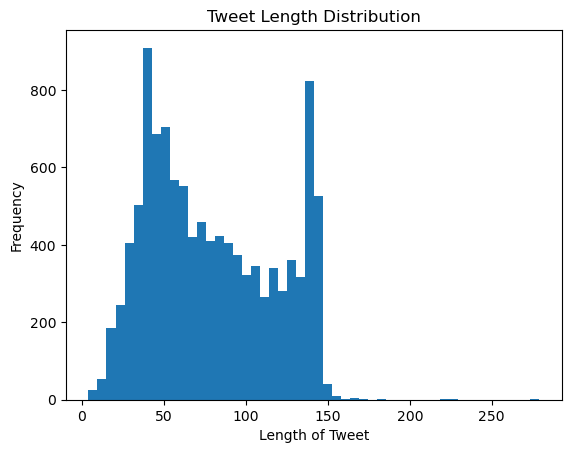

In [13]:
# Step 2: Tweet text structure

import matplotlib.pyplot as plt

# Add Tweet length column
df_cleaned['tweets_length'] = df_cleaned['post_text'].apply(len)

# Summary stat
print(df_cleaned['tweets_length'].describe())

# plot distribution
plt.hist(df_cleaned['tweets_length'], bins=50)
plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

### Analysis Insight:
- **Short tweets (under 50)** — maybe impulsive or emotional reaction.
- **Medium to long tweets** — maybe articulate explanation or rant type.
- These features could be important for depression prediction.
- **Bimodal shape**: Graph has 2 peaks — first one around 40-50 characters and second one 140-150 characters.
   - it maybe because some people are most likely to do short tweets and some tend to do long tweets.

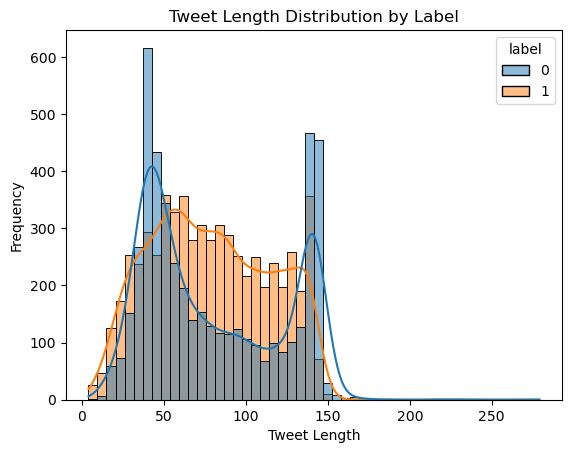

In [15]:
# Label-wise length distribution:

import seaborn as sns

df_cleaned['tweets_length'] = df_cleaned['post_text'].apply(len)

sns.histplot(data=df_cleaned, x='tweets_length', hue='label', bins=50, kde=True)
plt.title('Tweet Length Distribution by Label')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

| Observation            | Detail                                                                                                                                                                                                                          |
| ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Color Codes**        | `Blue` bars/line = Label 0 (Non-depressed) <br> `Orange` bars/line = Label 1 (Depressed)                                                                                                                                        |
| **Distribution Shape** | -  Non-depressed users -> sharply clustered tweets. <br> -  Depressed users ->  uniformly spread tweets.                                                                                                 |
| **Peak Positions**     | - Non-depressed users -> peak at around **40** and **140** length. <br> - Depressed users-> peak at around **60–80** length.                                                                                         |
| **Interpretation**     | - Depressed users tend to write long tweets, in which the express thoughts and emotions. <br> - Non-depressed users tend to write short and concised tweets, and that too mostly in promotional/neutral tone. |
| **Overlap**            | Both classes do have overlap, but depressed tweets have *evenly spread* distribution.                                                                                                                            |


In [17]:
# Step 3: Text Cleaning

import re  # Regular expressions (for removing URLs etc.)
import string # For punctuation
import nltk # Natural language toolkit
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# First-time only (run once)
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
# Initialize tools
stop_words=set(stopwords.words('english'))
lemmatizer= WordNetLemmatizer()

def clean_text(text):
    # 1. Lowercase
    text=text.lower()
    # 2. Remove URLs
    text=re.sub(r'http\S+|www\S+|https\S+','',text,flags=re.MULTILINE)
    # 3. Remove mentions & hashtags
    text=re.sub(r'@\w+|#\w+','',text)
    # 4. Remove punctuation
    text=text.translate(str.maketrans('', '', string.punctuation))
    # 5. Remove numbers
    text=re.sub(r'\d+', '', text)
    # 6. Remove extra whitespace
    text=re.sub(r'\s+', ' ' , text).strip()
    # 7. Tokenize & Remove stopwords & Lemmatize
    words=text.split()
    words=[lemmatizer.lemmatize(word) for word in words if word not in stop_words]

    return ' '.join(words)



In [19]:
# Apply Function on Dataset
df_cleaned['clean_text'] = df_cleaned['post_text'].apply(clean_text)

In [20]:
print('Original Tweet:\n', df_cleaned['post_text'].iloc[0])
print('\nCleaned Tweet:\n', df_cleaned['clean_text'].iloc[0])

Original Tweet:
 It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.

Cleaned Tweet:
 year since diagnosed today im taking moment reflect far ive come since


**Now:**

- all lowercase ✔️
- Hashtags, punctuation, numbers, stopwords are removed✔️
- Words have been lemmatized (e.g. "taking" → "take" expected)
- Only meaningful structure✔️

In [22]:
import sys
!{sys.executable} -m pip install wordcloud

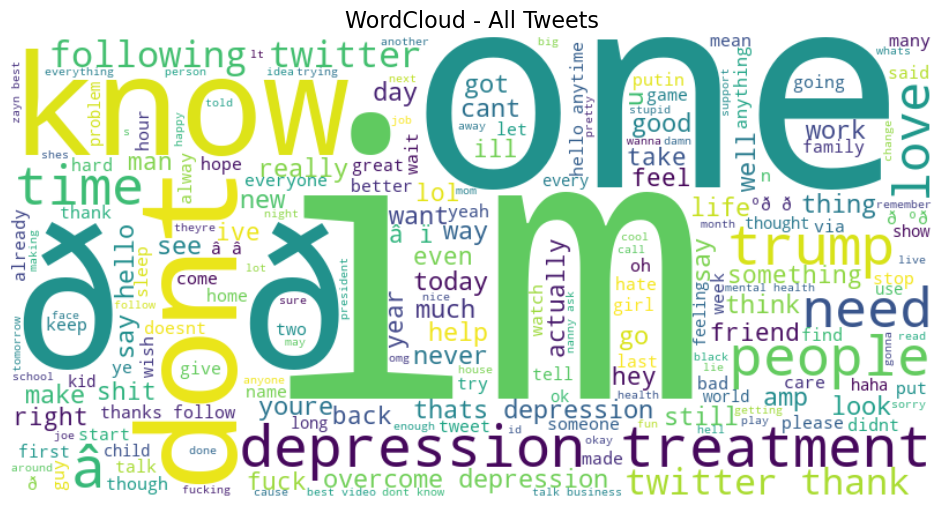

In [23]:
# Step 4: WordCloud (All Tweets)

from wordcloud import WordCloud

# Join all clean tweets into one big string
all_words =' '.join(df_cleaned['clean_text'])

# Create and plot word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - All Tweets', fontsize=16)
plt.show()

***This WordCloud is built from all tweets in our dataset (both depressed and non-depressed).***

### Key Observations:
**Large Words (appear most often):**

- "know", "one", "dont", "depression", "treatment", "need", "people"

**Medium Words:**

- "life", "feel", "say", "help", "never", "cant", "fuck", "thanks", "love"

**Small Words (less frequent but still present):**

- "hope", "job", "problem", "support", "overcome", "health", etc.

These words represent the most common tokens across all tweets after cleaning. Some of these are neutral (e.g., “know”, “say”), while others hint at mental health topics (like “depression”, “treatment”, “feel”, “help”).

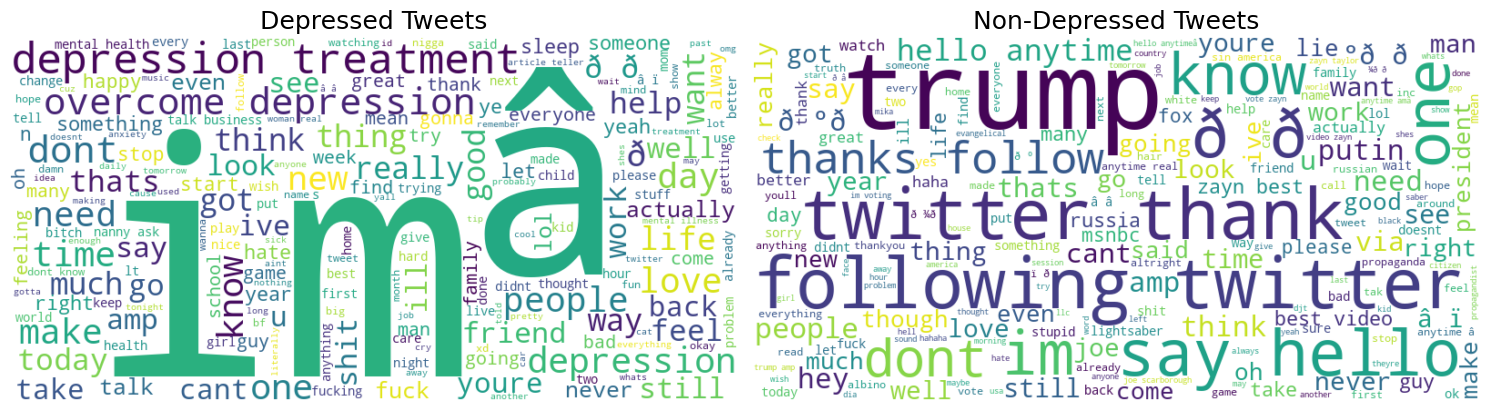

In [52]:
# Step 5: WordCloud by Label

# Depressed tweets
depressed_words=' '.join(df_cleaned[df_cleaned['label'] == 1]['clean_text'])
wordcloud_depressed= WordCloud(width=800, height=400, background_color='white').generate(depressed_words)

# Non-depressed tweets
non_depressed_words= ' '.join(df_cleaned[df_cleaned['label']==0]['clean_text'])
wordcloud_non_depressed=WordCloud(width=800, height=400, background_color='white').generate(non_depressed_words)

# Plot
plt.figure(figsize=(15,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_depressed, interpolation='bilinear')
plt.axis("off")
plt.title('Depressed Tweets', fontsize=18)

plt.subplot(1,2,2)
plt.imshow(wordcloud_non_depressed, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Depressed Tweets', fontsize=18)

plt.tight_layout()
plt.show()

- Words like "depression", "treatment", "bitch", "ill", "over come" appear in Depressed tweets.
- Words like "say hello", "following", "follow", "twitter", "love", "tanks" appear in Non-Depressed tweets.
- This contrast helps in feature selection and building an intelligent ML model.

In [58]:
# Step 6: Convert Text into Numerical Format (Feature Extraction)
# TF-IDF Vectorization Step-by-Step:
# 1. Import the TF-IDF Vectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

# 2. Initialize the Vectorizer
tfid=TfidfVectorizer(max_features=5000)

#  3. Fit and Transform the Clean Text
X = tfid.fit_transform(df_cleaned['clean_text']).toarray() # Features
y = df_cleaned['label'] # Labels (0 or 1)

- **X:** Each tweet is now a vector of numbers (features).
- **y:** Corresponding label — 0 (Non-Depressed) or 1 (Depressed)

In [29]:
# 4. Split the Data for Training and Testing

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2, random_state=42)

In [30]:
# Step 6: Train Machine Learning Models
# 1. Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize and Train Model
lr=LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [31]:
# Predict on Test Data
y_pred_lr=lr.predict(X_test)

# Evaluate
print(f'Accuracy Score of Linear Regression: {accuracy_score(y_test, y_pred_lr):.2f}')
print(f'\nClassification Report of Linear Regression:\n {classification_report(y_test, y_pred_lr)}')
print(f'\nConfusion Matrix of Linear Regression:\n {confusion_matrix(y_test, y_pred_lr)}')

Accuracy Score of Linear Regression: 0.79

Classification Report of Linear Regression:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75       960
           1       0.79      0.85      0.82      1234

    accuracy                           0.79      2194
   macro avg       0.79      0.79      0.79      2194
weighted avg       0.79      0.79      0.79      2194


Confusion Matrix of Linear Regression:
 [[ 688  272]
 [ 180 1054]]


In [32]:
# 2. RandomForest

from sklearn.ensemble import RandomForestClassifier

# initialize and train model
rf=RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [33]:
# predict on test data
y_pred_rf=rf.predict(X_test)

#Evaluate
print(f'Accuracy Score of Random Forest: {accuracy_score(y_test, y_pred_rf):.2f}')
print(f'\nClassification Report of Random Forest:\n {classification_report(y_test, y_pred_rf)}')
print(f'\nConfusion Matrix of Random Forest:\n {confusion_matrix(y_test, y_pred_rf)}')

Accuracy Score of Random Forest: 0.76

Classification Report of Random Forest:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72       960
           1       0.78      0.79      0.78      1234

    accuracy                           0.76      2194
   macro avg       0.75      0.75      0.75      2194
weighted avg       0.76      0.76      0.76      2194


Confusion Matrix of Random Forest:
 [[689 271]
 [263 971]]


In [36]:
import sys
!{sys.executable} -m pip install xgboost

  Using cached xgboost-3.0.3-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/149.9 MB 1.4 MB/s eta 0:01:50
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.0 kB/s eta 0:02:32
   ---------------------------------------- 0.0/149.9 MB 991.

In [49]:
# 3. Naive bayes ,SVM , XGBoost
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

models={"Naive Bayes": MultinomialNB(), "SVM": SVC(kernel='linear'), "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')}

for name, model in models.items():
    print(f"\n🔍 Running model: {name}")
    try:
        model.fit(X_train, y_train)
        preds= model.predict(X_test)
        acc= accuracy_score(y_test, preds)
        cr= classification_report(y_test, preds)
        cm= confusion_matrix(y_test, preds)
        print(f"Accuracy Score of {name}: {acc:.2f}")
        print(f'\nClassification Report of {name}:\n {cr}')
        print(f'\nConfusion Matrix of {name}:\n {cm}')

    except Exception as e:
        print(f"❌ Error in model {name}: {e}")


🔍 Running model: Naive Bayes
Accuracy Score of Naive Bayes: 0.77

Classification Report of Naive Bayes:
               precision    recall  f1-score   support

           0       0.87      0.56      0.68       960
           1       0.73      0.93      0.82      1234

    accuracy                           0.77      2194
   macro avg       0.80      0.75      0.75      2194
weighted avg       0.79      0.77      0.76      2194


Confusion Matrix of Naive Bayes:
 [[ 539  421]
 [  84 1150]]

🔍 Running model: SVM
Accuracy Score of SVM: 0.80

Classification Report of SVM:
               precision    recall  f1-score   support

           0       0.79      0.74      0.76       960
           1       0.80      0.85      0.82      1234

    accuracy                           0.80      2194
   macro avg       0.80      0.79      0.79      2194
weighted avg       0.80      0.80      0.80      2194


Confusion Matrix of SVM:
 [[ 707  253]
 [ 191 1043]]

🔍 Running model: XGBoost


C:\Users\DELL\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:00:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy Score of XGBoost: 0.70

Classification Report of XGBoost:
               precision    recall  f1-score   support

           0       0.89      0.36      0.52       960
           1       0.66      0.96      0.78      1234

    accuracy                           0.70      2194
   macro avg       0.77      0.66      0.65      2194
weighted avg       0.76      0.70      0.67      2194


Confusion Matrix of XGBoost:
 [[ 349  611]
 [  45 1189]]


| Model              | Accuracy | F1-Score (1) | Notes                |
| ------------------ | -------- | ------------ | -------------------- |
| LogisticRegression | 0.79     | 0.82         | Balanced             |
| RandomForest       | 0.77     | 0.79         | Slightly overfits    |
| Naive Bayes        | 0.77     | 0.82         | Biased toward 1      |
| SVM                | 0.80     | 0.82         | 🔥 Best overall      |
| XGBoost            | 0.70     | 0.78         | Biased, needs tuning |


In [68]:
# Step 7. Tune SVM with GridSearchCV 

# Tuning my best model (SVM) using GridSearchCV to find the best hyperparameters and improve performance.

# 1. Import Required Libraries
from sklearn.model_selection import GridSearchCV

# 2. Define Parameter Grid
#You’ll test different values of C (regularization strength) and kernel type:
param_grid = {
    'C': [1, 10],         # fewer values
    'kernel': ['linear'], # remove 'rbf' for now (very slow!)
}

# 3. Initialize Model and GridSearchCV
svm=SVC()
grid=GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# 4. Fit on Training Data
# Sample smaller dataset for quick grid search
from sklearn.utils import resample
X_small, y_small = resample(X_train, y_train, n_samples=5000, random_state=42)

# Fit on small data
grid.fit(X_small, y_small)


Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10], 'kernel': ['linear']},
             scoring='accuracy', verbose=2)

In [72]:
# 5. Check Best Parameters and Accuracy
print("Best Parameters: ", grid.best_params_)
print("Best Cross-Validated Accuracy: ", grid.best_score_)

Best Parameters:  {'C': 1, 'kernel': 'linear'}
Best Cross-Validated Accuracy:  0.8188001055251135


In [74]:
# 6. Evaluate on Test Set
best_model=grid.best_estimator_

# Predict on test data
y_pred_gscv=best_model.predict(X_test)

# Evaluate
print("Test Accuracy: ", accuracy_score(y_test, y_pred_gscv))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gscv))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gscv))

Test Accuracy:  0.7643573381950775

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73       960
           1       0.78      0.80      0.79      1234

    accuracy                           0.76      2194
   macro avg       0.76      0.76      0.76      2194
weighted avg       0.76      0.76      0.76      2194


Confusion Matrix:
 [[689 271]
 [246 988]]


In [76]:
# Step 8. SMOTE for model improvement

from imblearn.over_sampling import SMOTE

# apply on training set
smote=SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [78]:
svm_model= SVC(kernel='linear')
svm_model.fit(X_train_smote, y_train_smote)

SVC(kernel='linear')

In [82]:
# evakuate on test model
y_pred_sm= svm_model.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, y_pred_sm))
print(f'\nClassification Report:\n {classification_report(y_test, y_pred_sm)}')
print(f'\nConfusion Matrix:\n {confusion_matrix(y_test, y_pred_sm)}')

Accuracy Score:  0.7752962625341842

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.79      0.75       960
           1       0.82      0.77      0.79      1234

    accuracy                           0.78      2194
   macro avg       0.77      0.78      0.77      2194
weighted avg       0.78      0.78      0.78      2194


Confusion Matrix:
 [[755 205]
 [288 946]]


#### Trade-off:
- Slight drop in recall for class 1 (Depressed), but overall balanced.
- This is normal when you fix class imbalance

In [85]:
!pip install streamlit

   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---------------------------------------- 0.0/413.7 kB ? eta -:--:--
   ---

### Model Deployment (Streamlit App)

***Building a model that takes any tweet as input and classifies it as either:
Depressed 😔 or Not Depressed 🙂***

In [116]:
import pickle

# Replace with your actual model and vectorizer
final_model = svm_model  # or whatever variable name you used
final_vectorizer = tfid      # your TF-IDF vectorizer

# Save model
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

# Save vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(final_vectorizer, f)


- 🔻 SVM model is too large (>25MB)
- ❌ Not deployable on Streamlit Cloud as-is
- 🐌 Slower inference time than Logistic Regression or Naive Bayes

#### ✅ Now What?
Now we will use Logistic Regression (79%):

##### ✅ Why Logistic Regression Makes Sense Now:
- Almost same accuracy (just 1% difference)
- Model file is very small (few MBs)
- Works great with TF-IDF
- Deploys easily on Streamlit Cloud
- Fast predictions
- Easy to explain

In [120]:
# Save with compression the logistic regression model

from joblib import dump
dump(lr, 'logistic_model.pkl', compress=3)

['logistic_model.pkl']